# **Dataset of pm2.5 with lat and lon only**

## **0. Load the modules**

In [100]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [101]:
# API Key and City Information
api_key = 'a693b748d40c2a70d69295b2caad893a'
city_name = 'Bangkok,TH'

## **1. Get Dataset API and convert to dataframe**

In [102]:
# Get coordinates from city name (Geocoding API)
geocode_url = f'http://api.openweathermap.org/geo/1.0/direct?q={city_name}&limit=1&appid={api_key}'
response = requests.get(geocode_url)
location_data = response.json()

if not location_data:
    raise ValueError("Invalid city name or no location data available.")

# List of monitoring stations with their coordinates
stations = [
    {'name': '3T', 'lat': 13.7563, 'lon': 100.5018},
    {'name': '5T', 'lat': 13.7367, 'lon': 100.5231},
    {'name': '10T', 'lat': 13.7291, 'lon': 100.7750},
    {'name': '11T', 'lat': 13.7898, 'lon': 100.4486},
    {'name': '12T', 'lat': 13.8225, 'lon': 100.5147},
    {'name': '15T', 'lat': 13.7083, 'lon': 100.3728},
    {'name': '61T', 'lat': 13.6796, 'lon': 100.6067},
    # {'name': '52T (Roadside, Bangkok)', 'lat': 13.7563, 'lon': 100.5018},
    # {'name': '54T (Roadside, Bangkok)', 'lat': 13.7367, 'lon': 100.5231}
]

In [103]:
# Fetch PM2.5 data for each station
start_date = int(pd.Timestamp("2023-01-01 00:00:00").timestamp())
end_date = int(pd.Timestamp.now().timestamp())

pm25_data = []

In [104]:
for station in stations:
    lat = station['lat']
    lon = station['lon']
    pollution_url = (
        f'http://api.openweathermap.org/data/2.5/air_pollution/history?'
        f'lat={lat}&lon={lon}&start={start_date}&end={end_date}&appid={api_key}'
    )
    
    response = requests.get(pollution_url)
    data = response.json()
    
    if 'list' in data:
        for entry in data['list']:
            dt = pd.to_datetime(entry['dt'], unit='s')
            pm2_5 = entry['components']['pm2_5']
            pm25_data.append({
                'datetime': dt,
                'station': station['name'],
                'lat': lat,
                'lon': lon,
                'pm2_5': pm2_5
            })
    else:
        print(f"No data available for station {station['name']} (lat={lat}, lon={lon})")

# Convert to DataFrame
pm25_df = pd.DataFrame(pm25_data)
print(pm25_df.head())

             datetime station      lat       lon   pm2_5
0 2023-01-01 00:00:00      3T  13.7563  100.5018  158.36
1 2023-01-01 01:00:00      3T  13.7563  100.5018  199.19
2 2023-01-01 02:00:00      3T  13.7563  100.5018  226.01
3 2023-01-01 03:00:00      3T  13.7563  100.5018  235.79
4 2023-01-01 04:00:00      3T  13.7563  100.5018  187.84


In [105]:
pm25_df.shape

(132538, 5)

In [106]:
pm25_df.head()

,datetime,station,lat,lon,pm2_5
0,2023-01-01 00:00:00,3T,13.7563,100.5018,158.36
1,2023-01-01 01:00:00,3T,13.7563,100.5018,199.19
2,2023-01-01 02:00:00,3T,13.7563,100.5018,226.01
3,2023-01-01 03:00:00,3T,13.7563,100.5018,235.79
4,2023-01-01 04:00:00,3T,13.7563,100.5018,187.84


In [107]:
pm25_df

,datetime,station,lat,lon,pm2_5
0,2023-01-01 00:00:00,3T,13.7563,100.5018,158.36
1,2023-01-01 01:00:00,3T,13.7563,100.5018,199.19
2,2023-01-01 02:00:00,3T,13.7563,100.5018,226.01
3,2023-01-01 03:00:00,3T,13.7563,100.5018,235.79
4,2023-01-01 04:00:00,3T,13.7563,100.5018,187.84
...,...,...,...,...,...
132533,2025-03-13 17:00:00,61T,13.6796,100.6067,29.20
132534,2025-03-13 18:00:00,61T,13.6796,100.6067,29.09
132535,2025-03-13 19:00:00,61T,13.6796,100.6067,31.42
132536,2025-03-13 20:00:00,61T,13.6796,100.6067,33.79


## **2. EDA**

In [108]:
pm25_df['datetime'].diff().value_counts()

datetime
0 days 01:00:00        132454
1 days 01:00:00            56
2 days 01:00:00            21
-803 days +03:00:00         6
Name: count, dtype: int64

### **Handling gaps**

In [109]:
actual_range = pd.date_range(start=pm25_df['datetime'].min(), end=pm25_df['datetime'].max(), freq='h')
actual_range

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2025-03-13 12:00:00', '2025-03-13 13:00:00',
               '2025-03-13 14:00:00', '2025-03-13 15:00:00',
               '2025-03-13 16:00:00', '2025-03-13 17:00:00',
               '2025-03-13 18:00:00', '2025-03-13 19:00:00',
               '2025-03-13 20:00:00', '2025-03-13 21:00:00'],
              dtype='datetime64[ns]', length=19270, freq='h')

In [110]:
# Create a new DataFrame with all datetime and station combinations
stations = pm25_df[['lat', 'lon']].drop_duplicates()

# Create full cartesian product of stations × timestamps
full_index = pd.MultiIndex.from_product([actual_range, stations.itertuples(index=False, name=None)], 
                                        names=["datetime", "station_info"])

In [111]:
# Convert station lat/lon to tuples for merging
pm25_df["station_info"] = list(zip(pm25_df["lat"], pm25_df["lon"]))

# Merge with full datetime-station grid to fill missing timestamps per station
full_df = pd.DataFrame(index=full_index).reset_index().merge(pm25_df, on=["datetime", "station_info"], how="left")

# Split 'station_info' back into separate lat/lon columns
full_df[["lat", "lon"]] = pd.DataFrame(full_df["station_info"].tolist(), index=full_df.index)

# Drop redundant column
full_df.drop(columns=["station_info"], inplace=True)

In [112]:
# Check for missing timestamps
print(full_df["datetime"].diff().value_counts())

print('\n')
print('-'*50)
print('I can understand that there can be a duplicate timestamp due to many stations are being recorded at the same time')

datetime
0 days 00:00:00    115620
0 days 01:00:00     19269
Name: count, dtype: int64


--------------------------------------------------
I can understand that there can be a duplicate timestamp due to many stations are being recorded at the same time


### **Check missing values**

In [113]:
full_df.isna().sum()

datetime       0
station     2352
lat            0
lon            0
pm2_5       2352
dtype: int64

### **Handling missing values**

In [114]:
# # Handling missing values for station

# # Sort data for consistency
# full_df.sort_values(by=['lat', 'lon', 'datetime'], inplace=True)

# # Fill missing station names using mode per (lat, lon) group
# full_df['station'] = full_df.groupby(['lat', 'lon'])['station'].transform(lambda x: x.mode()[0] if not x.mode().empty else None)

# # Final check
# print(full_df.isna().sum())

In [115]:
# # Handling missing PM2.5 values per station while keeping trends
# full_df.sort_values(by=['lat', 'lon', 'datetime'], inplace=True)

# # Reset index before interpolation
# full_df.reset_index(inplace=True)

# # Interpolate missing PM2.5 values per station
# full_df['pm2_5'] = full_df.groupby(['lat', 'lon'])['pm2_5'].transform(lambda group: group.interpolate(method='linear'))

# # Use backward fill for any remaining missing values
# full_df['pm2_5'].fillna(method='bfill', inplace=True)

# # Restore original index
# full_df.set_index('datetime', inplace=True)

# # Final check
# print(full_df.isna().sum())

### **Check unique values of lat and lon**

In [116]:
full_df['lat'].unique()

array([13.7563, 13.7367, 13.7291, 13.7898, 13.8225, 13.7083, 13.6796])

In [117]:
full_df['lon'].unique()

array([100.5018, 100.5231, 100.775 , 100.4486, 100.5147, 100.3728,
       100.6067])

In [118]:
full_df['station'].unique()

array(['3T', '5T', '10T', '11T', '12T', '15T', '61T', nan], dtype=object)

In [119]:
full_df.isna().sum()

datetime       0
station     2352
lat            0
lon            0
pm2_5       2352
dtype: int64

In [120]:
full_df.groupby(['lat', 'lon'])['station'].nunique()


lat      lon     
13.6796  100.6067    1
13.7083  100.3728    1
13.7291  100.7750    1
13.7367  100.5231    1
13.7563  100.5018    1
13.7898  100.4486    1
13.8225  100.5147    1
Name: station, dtype: int64

In [121]:
full_df[full_df['station'].isna()]


,datetime,station,lat,lon,pm2_5
8911,2023-02-23 01:00:00,NaN,13.7563,100.5018,NaN
8912,2023-02-23 01:00:00,NaN,13.7367,100.5231,NaN
8913,2023-02-23 01:00:00,NaN,13.7291,100.7750,NaN
8914,2023-02-23 01:00:00,NaN,13.7898,100.4486,NaN
8915,2023-02-23 01:00:00,NaN,13.8225,100.5147,NaN
...,...,...,...,...,...
133730,2025-03-07 00:00:00,NaN,13.7291,100.7750,NaN
133731,2025-03-07 00:00:00,NaN,13.7898,100.4486,NaN
133732,2025-03-07 00:00:00,NaN,13.8225,100.5147,NaN
133733,2025-03-07 00:00:00,NaN,13.7083,100.3728,NaN


In [122]:
full_df['station'].value_counts()


station
3T     18934
5T     18934
10T    18934
11T    18934
12T    18934
15T    18934
61T    18934
Name: count, dtype: int64

In [123]:
isna = full_df['station'].isna().value_counts() 

In [124]:
missing_stations = full_df[full_df['station'].isna()]
missing_stations

,datetime,station,lat,lon,pm2_5
8911,2023-02-23 01:00:00,NaN,13.7563,100.5018,NaN
8912,2023-02-23 01:00:00,NaN,13.7367,100.5231,NaN
8913,2023-02-23 01:00:00,NaN,13.7291,100.7750,NaN
8914,2023-02-23 01:00:00,NaN,13.7898,100.4486,NaN
8915,2023-02-23 01:00:00,NaN,13.8225,100.5147,NaN
...,...,...,...,...,...
133730,2025-03-07 00:00:00,NaN,13.7291,100.7750,NaN
133731,2025-03-07 00:00:00,NaN,13.7898,100.4486,NaN
133732,2025-03-07 00:00:00,NaN,13.8225,100.5147,NaN
133733,2025-03-07 00:00:00,NaN,13.7083,100.3728,NaN


In [125]:
full_df['lat'].unique()

array([13.7563, 13.7367, 13.7291, 13.7898, 13.8225, 13.7083, 13.6796])

In [126]:
full_df['lon'].unique()

array([100.5018, 100.5231, 100.775 , 100.4486, 100.5147, 100.3728,
       100.6067])

In [127]:
full_df.isna().sum()

datetime       0
station     2352
lat            0
lon            0
pm2_5       2352
dtype: int64

In [128]:
full_df.groupby('station')[['lat', 'lon']].nunique()

,lat,lon
station,,
10T,1,1
11T,1,1
12T,1,1
15T,1,1
3T,1,1
5T,1,1
61T,1,1


In [129]:
full_df.groupby(['lat', 'lon'])['station'].nunique()


lat      lon     
13.6796  100.6067    1
13.7083  100.3728    1
13.7291  100.7750    1
13.7367  100.5231    1
13.7563  100.5018    1
13.7898  100.4486    1
13.8225  100.5147    1
Name: station, dtype: int64

### **`Remove the (Roadside, Bangkok) emtries that shared the same lat, lon`**

In [130]:
full_df.groupby(['lat', 'lon'])['station'].unique()

lat      lon     
13.6796  100.6067    [61T, nan]
13.7083  100.3728    [15T, nan]
13.7291  100.7750    [10T, nan]
13.7367  100.5231     [5T, nan]
13.7563  100.5018     [3T, nan]
13.7898  100.4486    [11T, nan]
13.8225  100.5147    [12T, nan]
Name: station, dtype: object

In [131]:
full_df.head()

,datetime,station,lat,lon,pm2_5
0,2023-01-01,3T,13.7563,100.5018,158.36
1,2023-01-01,5T,13.7367,100.5231,158.36
2,2023-01-01,10T,13.7291,100.7750,63.83
3,2023-01-01,11T,13.7898,100.4486,71.83
4,2023-01-01,12T,13.8225,100.5147,158.36


In [132]:
full_df.index.diff().value_counts()

1.0    134889
Name: count, dtype: int64

In [133]:
full_df.isna().sum()

datetime       0
station     2352
lat            0
lon            0
pm2_5       2352
dtype: int64

## **3. Save the dataframe**

In [134]:
full_df.to_csv('pm25_bangkok_2025_lat_lon.csv', index=True)

In [135]:
full_df

,datetime,station,lat,lon,pm2_5
0,2023-01-01 00:00:00,3T,13.7563,100.5018,158.36
1,2023-01-01 00:00:00,5T,13.7367,100.5231,158.36
2,2023-01-01 00:00:00,10T,13.7291,100.7750,63.83
3,2023-01-01 00:00:00,11T,13.7898,100.4486,71.83
4,2023-01-01 00:00:00,12T,13.8225,100.5147,158.36
...,...,...,...,...,...
134885,2025-03-13 21:00:00,10T,13.7291,100.7750,34.96
134886,2025-03-13 21:00:00,11T,13.7898,100.4486,21.47
134887,2025-03-13 21:00:00,12T,13.8225,100.5147,33.04
134888,2025-03-13 21:00:00,15T,13.7083,100.3728,5.86


In [136]:
full_df.index.diff().value_counts()

1.0    134889
Name: count, dtype: int64

## **4. Try loading the saved dataset and start analysis**

In [137]:
df = pd.read_csv('pm25_bangkok_2025_lat_lon.csv', parse_dates=['datetime'])
df.head()

,Unnamed: 0,datetime,station,lat,lon,pm2_5
0,0,2023-01-01,3T,13.7563,100.5018,158.36
1,1,2023-01-01,5T,13.7367,100.5231,158.36
2,2,2023-01-01,10T,13.7291,100.7750,63.83
3,3,2023-01-01,11T,13.7898,100.4486,71.83
4,4,2023-01-01,12T,13.8225,100.5147,158.36


### **Validate the loaded dataframe**

In [138]:
df.isna().sum()

Unnamed: 0       0
datetime         0
station       2352
lat              0
lon              0
pm2_5         2352
dtype: int64

In [139]:
df.set_index('datetime', inplace=True)

In [140]:
df.index.diff().value_counts()

datetime
0 days 00:00:00    115620
0 days 01:00:00     19269
Name: count, dtype: int64

In [141]:
df.head()

,Unnamed: 0,station,lat,lon,pm2_5
datetime,,,,,
2023-01-01,0,3T,13.7563,100.5018,158.36
2023-01-01,1,5T,13.7367,100.5231,158.36
2023-01-01,2,10T,13.7291,100.7750,63.83
2023-01-01,3,11T,13.7898,100.4486,71.83
2023-01-01,4,12T,13.8225,100.5147,158.36


In [142]:
df.reset_index(inplace=True)
df

,datetime,Unnamed: 0,station,lat,lon,pm2_5
0,2023-01-01 00:00:00,0,3T,13.7563,100.5018,158.36
1,2023-01-01 00:00:00,1,5T,13.7367,100.5231,158.36
2,2023-01-01 00:00:00,2,10T,13.7291,100.7750,63.83
3,2023-01-01 00:00:00,3,11T,13.7898,100.4486,71.83
4,2023-01-01 00:00:00,4,12T,13.8225,100.5147,158.36
...,...,...,...,...,...,...
134885,2025-03-13 21:00:00,134885,10T,13.7291,100.7750,34.96
134886,2025-03-13 21:00:00,134886,11T,13.7898,100.4486,21.47
134887,2025-03-13 21:00:00,134887,12T,13.8225,100.5147,33.04
134888,2025-03-13 21:00:00,134888,15T,13.7083,100.3728,5.86


In [143]:
df

,datetime,Unnamed: 0,station,lat,lon,pm2_5
0,2023-01-01 00:00:00,0,3T,13.7563,100.5018,158.36
1,2023-01-01 00:00:00,1,5T,13.7367,100.5231,158.36
2,2023-01-01 00:00:00,2,10T,13.7291,100.7750,63.83
3,2023-01-01 00:00:00,3,11T,13.7898,100.4486,71.83
4,2023-01-01 00:00:00,4,12T,13.8225,100.5147,158.36
...,...,...,...,...,...,...
134885,2025-03-13 21:00:00,134885,10T,13.7291,100.7750,34.96
134886,2025-03-13 21:00:00,134886,11T,13.7898,100.4486,21.47
134887,2025-03-13 21:00:00,134887,12T,13.8225,100.5147,33.04
134888,2025-03-13 21:00:00,134888,15T,13.7083,100.3728,5.86


## **5. Feature engineering**

In [144]:
#Add more feature about time
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract hour as 'time'
df['hour'] = df['datetime'].dt.hour

# Extract month
df['month'] = df['datetime'].dt.month

# Extract day of the week as a number (0 as Monday to 6 as Sunday)
df['day_of_week'] = df['datetime'].dt.dayofweek

# Display the updated DataFrame
print(df.head())

    datetime  Unnamed: 0 station      lat       lon   pm2_5  hour  month  \
0 2023-01-01           0      3T  13.7563  100.5018  158.36     0      1   
1 2023-01-01           1      5T  13.7367  100.5231  158.36     0      1   
2 2023-01-01           2     10T  13.7291  100.7750   63.83     0      1   
3 2023-01-01           3     11T  13.7898  100.4486   71.83     0      1   
4 2023-01-01           4     12T  13.8225  100.5147  158.36     0      1   

   day_of_week  
0            6  
1            6  
2            6  
3            6  
4            6  


In [145]:
df2 = pd.read_csv(r'df2.csv',header=0)

In [146]:
df = df.merge(df2, on=['station'])

In [147]:
df.head()

,datetime,Unnamed: 0,station,lat,lon,pm2_5,hour,month,day_of_week,sea_level,population,population_density,household,household_density,green_space,green_space_area,factory_num,factory_area
0,2023-01-01,0,3T,13.7563,100.5018,158.36,0,1,6,23,64468,9046.87,58039,0.81,10.77,0.10,112,123059
1,2023-01-01,1,5T,13.7367,100.5231,158.36,0,1,6,10,40077,4788.74,32138,0.38,22.97,0.11,188,54185
2,2023-01-01,2,10T,13.7291,100.7750,63.83,0,1,6,20,179899,1452.45,105461,0.09,3.95,0.01,493,4770457
3,2023-01-01,3,11T,13.7898,100.4486,71.83,0,1,6,26,101330,3437.36,44465,0.15,13.76,0.05,77,144736
4,2023-01-01,4,12T,13.8225,100.5147,158.36,0,1,6,3,118634,10275.79,78240,0.68,2.30,0.02,272,297638


In [148]:
def map_season(month):
    if 3 <= month <= 4:
        return 'Hot Season'
    elif 5 <= month <= 10:
        return 'Rainy Season'
    else:
        return 'Cool Season'

# Apply the function to create a new 'season' column
df['season'] = df['month'].apply(map_season)

C:\Users\Aimmy\AppData\Local\Temp\ipykernel_30320\2605075261.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seasonal_pm25, x='season', y='pm2_5', palette='coolwarm')


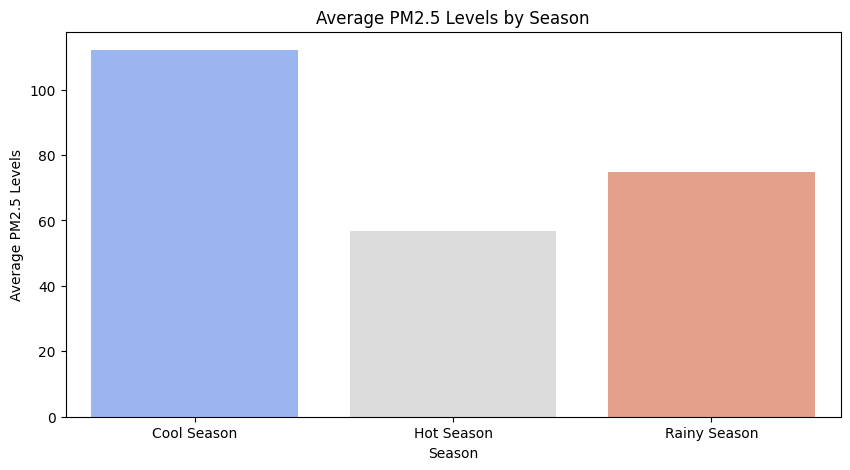

In [149]:
seasonal_pm25 = df.groupby('season')['pm2_5'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 5))
sns.barplot(data=seasonal_pm25, x='season', y='pm2_5', palette='coolwarm')
plt.title('Average PM2.5 Levels by Season')
plt.xlabel('Season')
plt.ylabel('Average PM2.5 Levels')
plt.show()

In [150]:
df=pd.get_dummies(df, columns=['season'], drop_first=True)

In [151]:
# Add time step column
# df['time_step'] = df.index.to_list()

In [152]:
# df['time_step'] 

In [153]:
# df.set_index('datetime', inplace=True)

In [154]:
df.dtypes

datetime               datetime64[ns]
Unnamed: 0                      int64
station                        object
lat                           float64
lon                           float64
pm2_5                         float64
hour                            int32
month                           int32
day_of_week                     int32
sea_level                       int64
population                      int64
population_density            float64
household                       int64
household_density             float64
green_space                   float64
green_space_area              float64
factory_num                     int64
factory_area                    int64
season_Hot Season                bool
season_Rainy Season              bool
dtype: object

In [155]:
df.columns

Index(['datetime', 'Unnamed: 0', 'station', 'lat', 'lon', 'pm2_5', 'hour',
       'month', 'day_of_week', 'sea_level', 'population', 'population_density',
       'household', 'household_density', 'green_space', 'green_space_area',
       'factory_num', 'factory_area', 'season_Hot Season',
       'season_Rainy Season'],
      dtype='object')

### **Visualize**

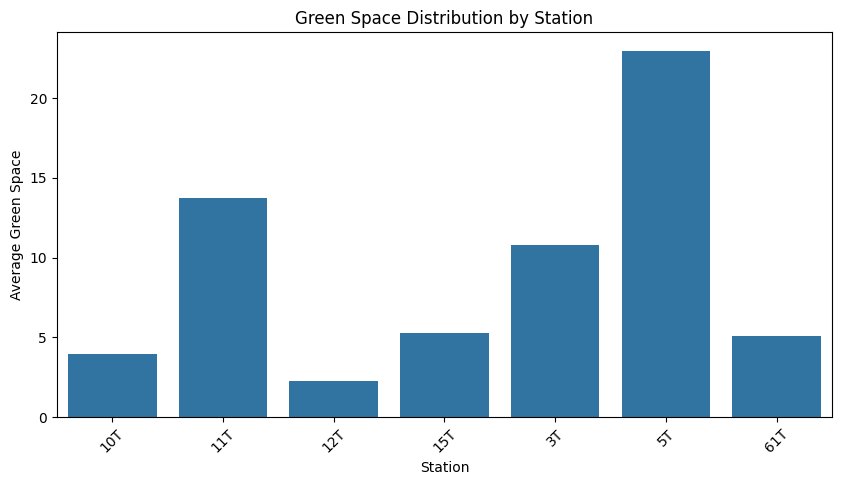

In [156]:
green_space_per_station = df.groupby('station')['green_space'].mean().reset_index()

# Create the bar graph
plt.figure(figsize=(10, 5))
sns.barplot(x='station', y='green_space', data=green_space_per_station)
plt.title('Green Space Distribution by Station')
plt.xlabel('Station')
plt.ylabel('Average Green Space')
plt.xticks(rotation=45)  # Rotate station names for better readability
plt.show()

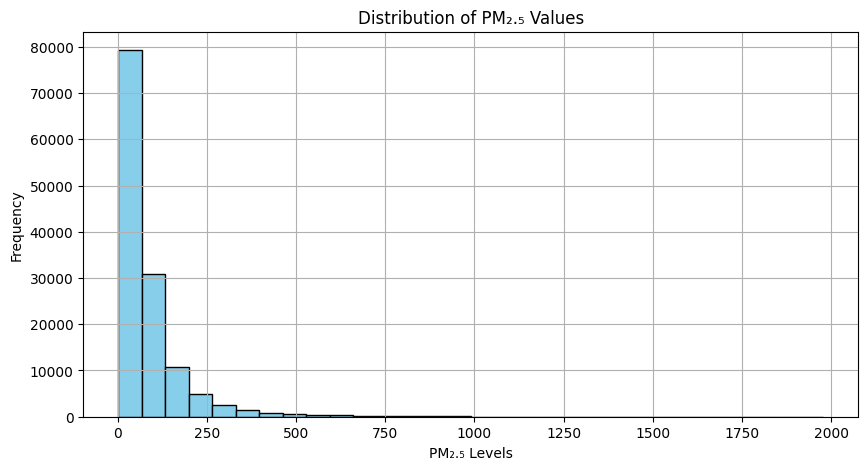

In [157]:
# Create histogram for PM2.5 distribution
plt.figure(figsize=(10, 5))
plt.hist(df['pm2_5'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of PM₂.₅ Values')
plt.xlabel('PM₂.₅ Levels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

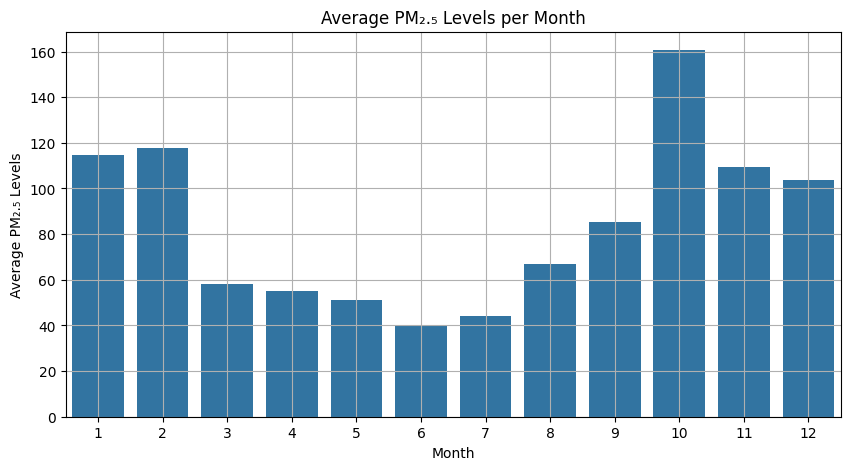

In [158]:
# Calculate average PM2.5 per month
average_pm25_per_month = df.groupby('month')['pm2_5'].mean().reset_index()

# Create bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=average_pm25_per_month, x='month', y='pm2_5')
plt.title('Average PM₂.₅ Levels per Month')
plt.xlabel('Month')
plt.ylabel('Average PM₂.₅ Levels')
plt.grid(True)
plt.show()

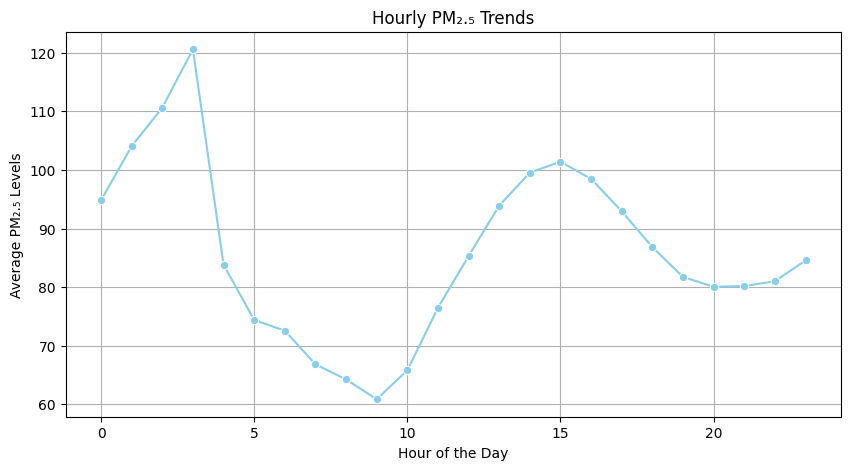

In [159]:
hourly_pm25_trends = df.groupby('hour')['pm2_5'].mean().reset_index()

# Create line plot for hourly trends
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_pm25_trends, x='hour', y='pm2_5', marker='o', color='skyblue')
plt.title('Hourly PM₂.₅ Trends')
plt.xlabel('Hour of the Day')
plt.ylabel('Average PM₂.₅ Levels')
plt.grid(True)
plt.show()

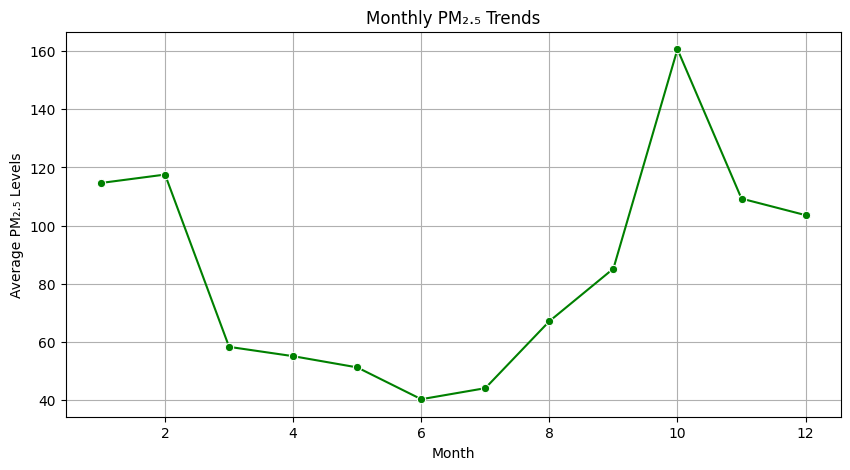

In [160]:
# You can reuse average_pm25_per_month calculated previously
average_pm25_per_month = df.groupby('month')['pm2_5'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=average_pm25_per_month, x='month', y='pm2_5', marker='o', color='green')
plt.title('Monthly PM₂.₅ Trends')
plt.xlabel('Month')
plt.ylabel('Average PM₂.₅ Levels')
plt.grid(True)
plt.show()

C:\Users\Aimmy\AppData\Local\Temp\ipykernel_30320\2316793127.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='day_of_week', y='pm2_5', palette='coolwarm')


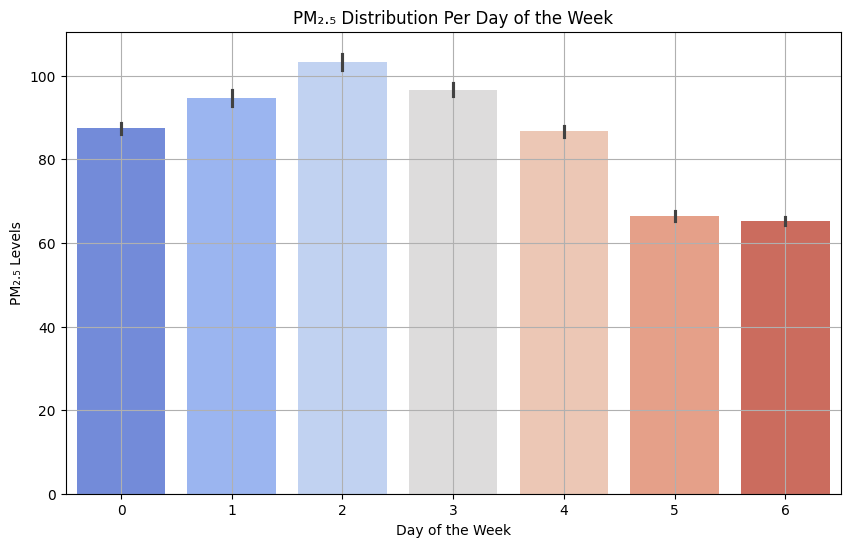

In [161]:
# Box plot for PM2.5 distribution per day of the week
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='day_of_week', y='pm2_5', palette='coolwarm')
plt.title('PM₂.₅ Distribution Per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('PM₂.₅ Levels')
plt.grid(True)
plt.show()

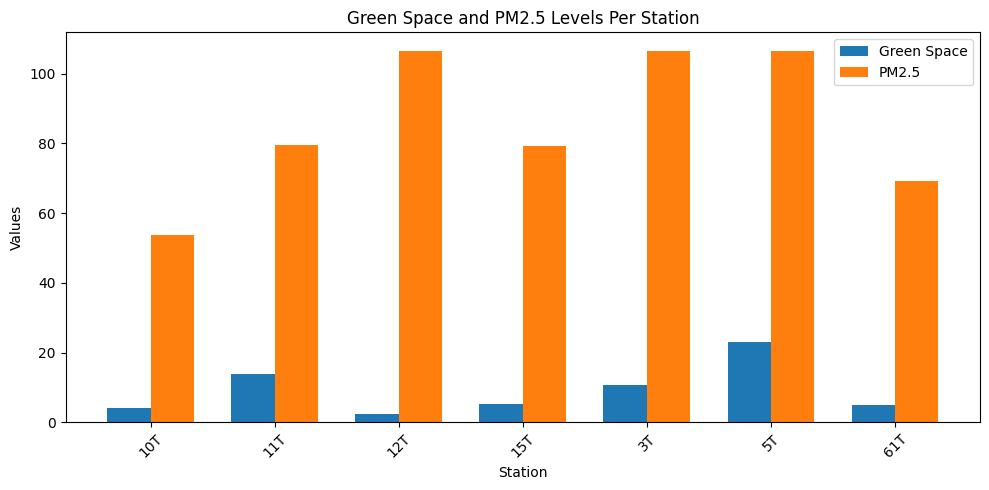

In [162]:
station_stats = df.groupby('station').agg({
    'green_space': 'mean',  # Average or sum of green space per station
    'pm2_5': 'mean'        # Average PM2.5 levels per station
}).reset_index()

# Create a grouped bar chart
plt.figure(figsize=(10, 5))
# Setting the positions for the bars
bar_width = 0.35
index = range(len(station_stats['station']))

# Plotting both 'green_space' and 'pm2_5' data
bars1 = plt.bar(index, station_stats['green_space'], bar_width, label='Green Space')
bars2 = plt.bar([p + bar_width for p in index], station_stats['pm2_5'], bar_width, label='PM2.5')

# Adding labels, title, and legend
plt.xlabel('Station')
plt.ylabel('Values')
plt.title('Green Space and PM2.5 Levels Per Station')
plt.xticks([p + bar_width / 2 for p in index], station_stats['station'], rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

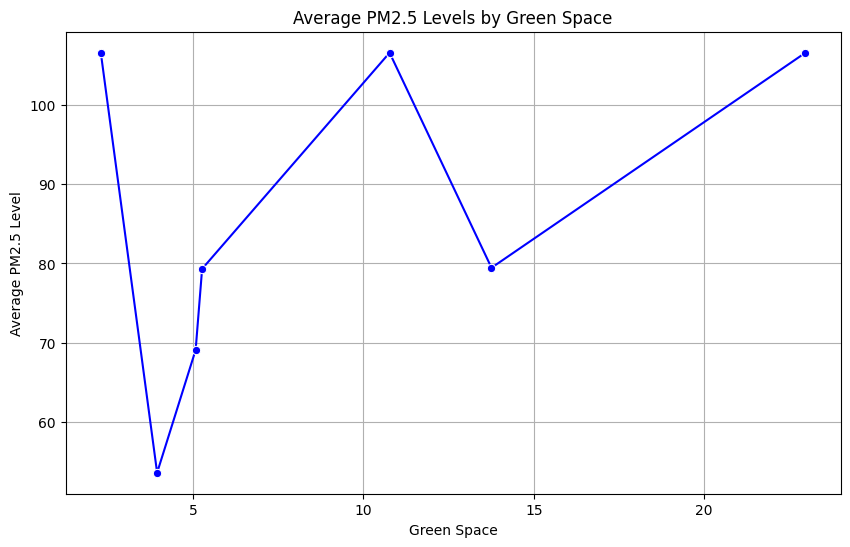

In [163]:
average_pm25_by_greenspace = df.groupby('green_space')['pm2_5'].mean().reset_index()
average_pm25_by_greenspace = average_pm25_by_greenspace.sort_values('green_space')

# Create a line plot for the average PM2.5 levels by green space
plt.figure(figsize=(10, 6))
sns.lineplot(x='green_space', y='pm2_5', data=average_pm25_by_greenspace, marker='o', color='blue')
plt.title('Average PM2.5 Levels by Green Space')
plt.xlabel('Green Space')
plt.ylabel('Average PM2.5 Level')
plt.grid(True)  # Optional: Adds a grid for better readability
plt.show()


### **We need to use these analysis**
- Trend analysis
- Cyclicity analysis
- Seasonal analysis

In [ ]:
# Selected features for heatmap correlation analysis
selected_cols = ['lat', 'lon','pm2_5','sea_level', 'hour','month','day_of_week', 'population', 'population_density', 'household', 'household_density','green_space', 'green_space_area','factory_num', 'factory_area', 'season_Hot Season', 'season_Rainy Season']

### **Heatmap with `pearson` method: Good for linear relationship**

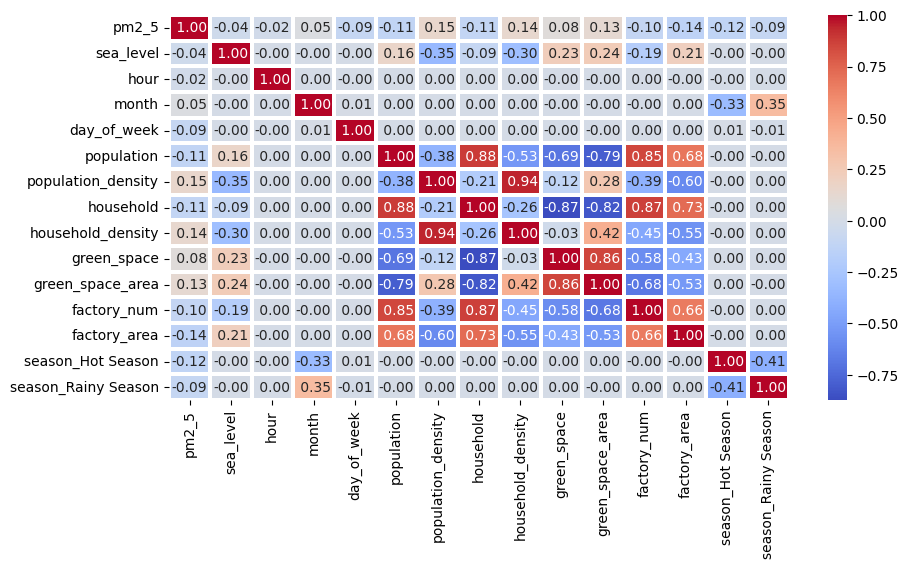

In [165]:
corr_matrix = df[selected_cols].corr(method='pearson')
corr_matrix

# Plotting the heatmap for numerical columns
plt.figure(figsize=(10,5))
sns.heatmap(data=corr_matrix, cmap='coolwarm', fmt=' .2f', annot=True, linewidths=1.5)
plt.show()

### **Heatmap with `spearman` method: Good for non-linear relationship**

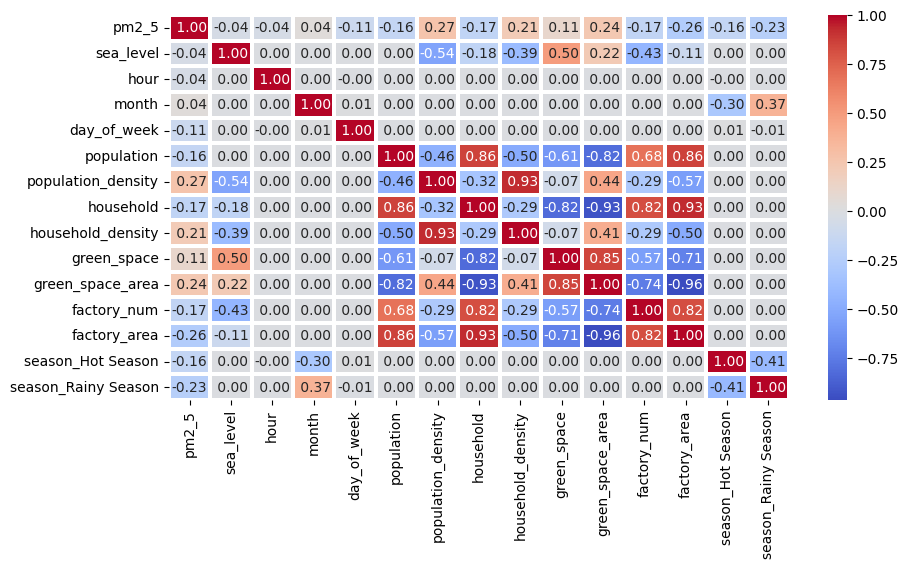

In [166]:
corr_matrix = df[selected_cols].corr(method='spearman')
corr_matrix

# Plotting the heatmap for numerical columns
plt.figure(figsize=(10,5))
sns.heatmap(data=corr_matrix, cmap='coolwarm', fmt=' .2f', annot=True, linewidths=1.5)
plt.show()

### **We use `spearman` method of correlation** 
- Because we are relying on rendom forest, XGBoost, Decision Tree!
- This is the non-parametric method!
- And we will compare performance for these 3 models (non-parametric method) to Linear models like Linear Regression, Ridge, Lasso Regression (Parametric method), and non-machine-learning method such as moving average to make sure that our assumption of non-parametric method is the best suited for PM2.5 prediction
- Additionally, spearman (non-linear relation) captures relationship better than pearson (Linear relation)

## **6. Feature selection**

### **Choose the most salient X**
- Rule of thumb: Good features MUST NOT BE correlated, i.e., independent
- Rule of thumb: Correlation is not causation; don’t pick features using correlation only; it should make sense!
- Rule of thumb: For ML, less features are usually better (but NOT necessarily for DL)

### **Specify the y**

### **Split train / test**

In [167]:
features = df[['population_density','factory_area','season_Hot Season', 'season_Rainy Season']]
target = df['pm2_5']

In [168]:
# Selecting X and y features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

In [169]:
X_train

,population_density,factory_area,season_Hot Season,season_Rainy Season
82890,3437.36,144736,False,True
16340,1452.45,4770457,True,False
126622,4542.29,631723,False,False
101661,9046.87,123059,False,True
30376,3437.36,144736,False,True
...,...,...,...,...
110268,10275.79,297638,False,True
119879,10275.79,297638,False,False
103694,3437.36,144736,False,True
131932,3437.36,144736,True,False


In [170]:
X_test

,population_density,factory_area,season_Hot Season,season_Rainy Season
30811,10275.79,297638,False,True
24784,10275.79,297638,False,True
46354,9046.87,123059,False,True
48040,4542.29,631723,False,True
13770,4788.74,54185,True,False
...,...,...,...,...
111203,4788.74,54185,False,False
54600,9046.87,123059,False,False
3377,3437.36,144736,False,False
72664,10275.79,297638,True,False


In [171]:
y_train

82890      19.77
16340      22.66
126622     99.46
101661     43.06
30376      16.07
           ...  
110268    550.57
119879     61.50
103694      8.01
131932     83.88
121958    213.60
Name: pm2_5, Length: 119284, dtype: float64

In [172]:
y_test

30811      92.66
24784      90.74
46354      61.78
48040      92.88
13770      39.16
           ...  
111203    192.50
54600     110.26
3377       88.48
72664      25.59
93206      32.59
Name: pm2_5, Length: 13254, dtype: float64

In [173]:
X_train

,population_density,factory_area,season_Hot Season,season_Rainy Season
82890,3437.36,144736,False,True
16340,1452.45,4770457,True,False
126622,4542.29,631723,False,False
101661,9046.87,123059,False,True
30376,3437.36,144736,False,True
...,...,...,...,...
110268,10275.79,297638,False,True
119879,10275.79,297638,False,False
103694,3437.36,144736,False,True
131932,3437.36,144736,True,False


In [174]:
X_train.isna().sum()

population_density     0
factory_area           0
season_Hot Season      0
season_Rainy Season    0
dtype: int64

In [175]:
X_test.isna().sum()

population_density     0
factory_area           0
season_Hot Season      0
season_Rainy Season    0
dtype: int64

In [176]:
y_train.shape

(119284,)

In [177]:
y_train.isna().sum()

np.int64(0)

In [178]:
y_test.shape

(13254,)

In [179]:
y_test.isna().sum()

np.int64(0)

### **Handling Missing Values After Spliting**

In [180]:
# Drop missing values in y_train and y_test
X_train = X_train[~y_train.isna()]
y_train = y_train.dropna()

X_test = X_test[~y_test.isna()]
y_test = y_test.dropna()

## **7. Modeling**

### **Modeling using non-parametric method (`XGBoost`, `RandomForest`, `DecisionTree`)**

#### **Scaling for `XGBoost` model**
- We will use these scaled X features for `XGBoost` model only

In [181]:
# Try StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [182]:
# Checking XGBoost Scaling
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3
count,1.192840e+05,1.192840e+05,1.192840e+05,1.192840e+05
mean,1.854926e-16,-1.346221e-17,1.191346e-18,5.833129e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.365095e+00,-6.180545e-01,-4.464621e-01,-9.178206e-01
25%,-6.799969e-01,-5.742038e-01,-4.464621e-01,-9.178206e-01
50%,-2.986269e-01,-4.630527e-01,-4.464621e-01,-9.178206e-01
75%,1.256143e+00,7.886486e-02,-4.464621e-01,1.089538e+00
max,1.680309e+00,2.384704e+00,2.239832e+00,1.089538e+00


In [183]:
# Import modules for modeling
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# Double-Check Time Splits (Data Leakage Check)
print("Train Date Range:", X_train.index.min(), "to", X_train.index.max())
print("Test Date Range:", X_test.index.min(), "to", X_test.index.max())

In [ ]:
# Define the models
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

# Define hyperparameter grids
param_grids = {
    "RandomForest": {
        "n_estimators": [1000, 1500, 2000],
        "max_depth": [25, 30, 35],
        "min_samples_split": [10, 15, 20]
    },
    "XGBoost": {
        "n_estimators": [1000, 1500, 2000],
        "learning_rate": [0.1, 0.01, 0.001],
        "max_depth": [25, 30, 35],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 1],
    },
    "DecisionTree": {
        "max_depth": [25, 30, 35],
        "min_samples_split": [10, 15, 20]
    }
}

In [ ]:
# Perform Cross-Validation and GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

best_models = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Use scaled data for XGBoost, but original data for RF and DT
    X_train_used = X_train_scaled if model_name == "XGBoost" else X_train
    X_test_used = X_test_scaled if model_name == "XGBoost" else X_test

    # GridSearchCV
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    grid_search.fit(X_train_used, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Cross-validation RMSE
    scores = cross_val_score(best_model, X_train_used, y_train, cv=5, scoring="neg_mean_squared_error")
    mean_cv_rmse = np.sqrt(-scores.mean())

    # Cross-validation R² Score
    cv_r2_scores = cross_val_score(best_model, X_train_used, y_train, cv=5, scoring="r2")
    mean_cv_r2 = cv_r2_scores.mean()

    # Evaluate on test set
    y_pred = best_model.predict(X_test_used)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)  # Compute R² score

    # Print RMSE & R² scores
    print(f"{model_name} Mean CV Score (RMSE): {mean_cv_rmse}")
    print(f"{model_name} Mean CV R² Score: {mean_cv_r2}")
    print(f"{model_name} Test RMSE: {test_rmse}")
    print(f"{model_name} Test R² Score: {test_r2}\n")

In [ ]:
# # Perform Cross-Validation and GridSearchCV

# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

# best_models = {}

# for model_name, model in models.items():
#     print(f"Training {model_name}...")

#     # Use scaled data for XGBoost, but original data for RF and DT
#     X_train_used = X_train_scaled if model_name == "XGBoost" else X_train
#     X_test_used = X_test_scaled if model_name == "XGBoost" else X_test

#     # GridSearchCV
#     grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
#     grid_search.fit(X_train_used, y_train)

#     # Best model
#     best_model = grid_search.best_estimator_
#     best_models[model_name] = best_model

#     # Cross-validation
#     scores = cross_val_score(best_model, X_train_used, y_train, cv=5, scoring="neg_mean_squared_error")
#     print(f"{model_name} Mean CV Score (RMSE): {np.sqrt(-scores.mean())}")

#     # Evaluate on test set
#     y_pred = best_model.predict(X_test_used)
#     test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     print(f"{model_name} Test RMSE: {test_rmse}\n")
